## Introduction
Federated learning is a machine learning setting where multiple entities collaborate in solving a machine learning
problem. Each client’s dataset is stored locally and not exchanged or transferred, instead local models are trained on the local data and only the model weights are sent to the central server. Federated Learning represents a possible solution to the problem of data privacy and data security in machine learning.

In this project I implemented the Federated Learning algorithm **FedAvg** formulated by McMahan, et al. [1] which is a first approach to this challange and it is considered as the baseline for Federated Learning.


Basically the algorithm is divided into two phases: the **Client Update** and the **Server Update**. In the **Client Update** phase, each client trains its local model on its local sample of data for the number of local epochs, using the local batch size. In the **Server Update** phase, the server averages the models weights of all the clients to create a new global model. This global model is then sent to all the clients to start a new round of training. In this way, the server never has access to the raw data but only to the model weights, and the global model is a good approximation of the model that would have been obtained by training on the entire dataset.

## Implementation


### Client
Each client has its own dataloader, model and optimizer, the learning rate and the number of local epochs can be set by the user. The method `train` implements the **Client Update** phase.

```python
def train(self, num_epochs, patience, params, progress_bar):
    self.model.load_state_dict(params)
    self.model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch_idx, (x, y) in enumerate(self.data):
            x, y = x.to(self.device), y.to(self.device)
            self.optimizer.zero_grad()
            y_pred = self.model(x)
            loss = self.loss_func(y_pred, y)
            loss.backward()
            self.optimizer.step()
            running_loss += loss.item()
        progress_bar.update(1)
    progress_bar.set_postfix({"loss": running_loss / len(self.data)})
    return running_loss / len(self.data)
```

### Server
The server has its own model and a method `aggregate` that implements the **Server Update** phase. Notice that the function does not return the new global model but it updates the model inplace.

```python
def aggregate(self, sample_clients):
    params = [client.get_params() for client in sample_clients]
    avg_params = {}
    for key in params[0].keys():
        avg_params[key] = torch.stack(
            [params[i][key] for i in range(len(params))], 0
        ).mean(0)
    self.model.load_state_dict(avg_params)
```

### Algorithm
The algorithm run for `T` rounds, first the server get the current global model state and then sends it to all the clients. Next the clients train their local model, which they updated to the new one, moving into their local optimizer direction for local epochs step and then they send the model back to the server. The server aggregates the models and sends the new global model to all the clients. At the end of the training the server evaluates the model on the test set.

```python
def fedSgdPar(
    model=Cnn(),
    T=5,                # number of rounds
    K=10,               # number of clients
    C=1,                # fraction of clients
    E=10,               # number of local epochs
    B=128,              # local batch size
    num_samples=1000,   # number of training samples on each client
    lr=0.01,            # learning rate
    weight_decay=10e-6, # weight decay
    patience=5,         # patience for early stopping
    noiid=False,        # non-iid data
    verbose=True
):
    # ... code ...
    clients = []
    for i in range(K):
        client = Client(
            i,
            trainloader[i],
            Cnn() if model.get_type() == "Cnn" else Net(),
            lr=lr,
            weight_decay=weight_decay,
            device=device,
        )
        clients.append(client)
    # ... code ...
    clients_each_round = max(int(K * C), 1)
    early_stopper = EarlyStopper(patience, min_delta=10e-3)
    for r in range(T):
        params = server.get_params()
        progress_bar = tqdm.tqdm(
            total=E * clients_each_round, position=0, leave=False, desc="Round %d" % r
        )
        random_clients = random.sample(clients, clients_each_round)
        joblib.Parallel(n_jobs=8, backend="threading")(
            joblib.delayed(client.train)(E, params, progress_bar)
            for client in random_clients
        )
        server.aggregate(random_clients)
        val_loss, val_acc = server.test(valoader)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        if early_stopper.early_stop(val_loss):
            if verbose:
                print("Early stopping")
            break
        if verbose:
            print("Server - Val loss: %.3f, Val accuracy: %.3f" % (val_loss, val_acc))

```

The dataset is splitted into training, validation and test set. The training set is divided into `K` clients, each client has a dataloader that samples `num_samples` samples from the training set. The validation set is used to evaluate the model at the end of each round, while the test set is used to evaluate the model at the end of the training.

To simulate the parallel training of clients on different devices, I used a thread-pool implementation from the `joblib` module. First I create `K` clients, then I sample `C*K` clients to train at each round.

This implemenation allows to test different configurations of the algorithm. In particular if we set `C = 1`, `E = 1` and `B = inf` we obtain the **FedSGD** algorithm, which is the baseline algorithm for the Federated Learning presented in the paper [1].

### FedAvg


In [1]:
def cal_sensitivity(lr, clip, dataset_size):
    return 2 * lr * clip / dataset_size

def Laplace(epsilon):
    return 1 / epsilon


def Gaussian_Simple(epsilon, delta):
    return np.sqrt(2 * np.log(1.25 / delta)) / epsilon



In [2]:
import torch.nn as nn
import torch.optim as optim
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class Client:
    """
    Client class for the federated learning process

    Args:
        id (int): Client id
        data (DataLoader): Data loader
        model (nn.Module): Model
        lr (float): Learning rate
        weight_decay (float): Weight decay
        device (str): Device
    """

    def __init__(self, id, data, model, lr=0.01, device=device):
        self.id = id
        self.data = data
        self.device = device
        self.model = model.to(device)
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr)
        self.loss_func = nn.MSELoss()
        self.dp_mechanism = 'Laplace'
        self.dp_epsilon = 0.1
        self.dp_delta = 1e-5
        self.dp_clip = 10
        self.times = 40 * 0.1
        self.noise_scale = self.calculate_noise_scale()



    def calculate_noise_scale(self):
        if self.dp_mechanism == 'Laplace':
            epsilon_single_query = self.dp_epsilon / self.times
            return Laplace(epsilon=epsilon_single_query)
        elif self.dp_mechanism == 'Gaussian':
            epsilon_single_query = self.dp_epsilon / self.times
            delta_single_query = self.dp_delta / self.times
            return Gaussian_Simple(epsilon=epsilon_single_query, delta=delta_single_query)

    def clip_gradients(self):
        if self.dp_mechanism == 'Laplace':
            self.per_sample_clip(self.model, self.dp_clip, norm=1)
        elif self.dp_mechanism == 'Gaussian':
            self.per_sample_clip(self.model, self.dp_clip, norm=2)

    def per_sample_clip(self, model, clipping, norm):
        # Collect the gradients from each parameter
        grad_samples = [p.grad for p in model.parameters() if p.grad is not None]

        # Calculate norms for each parameter's gradients
        per_param_norms = [g.reshape(len(g), -1).norm(norm, dim=-1) for g in grad_samples]

        # Calculate per-sample norms
        per_sample_norms = torch.stack(per_param_norms, dim=1).norm(norm, dim=1)

        # Calculate the clipping factor
        per_sample_clip_factor = torch.div(clipping, (per_sample_norms + 1e-6)).clamp(max=1.0)

        # Apply the clipping factor to each gradient
        for grad in grad_samples:
            factor = per_sample_clip_factor.reshape(per_sample_clip_factor.shape + (1,) * (grad.dim() - 1))
            grad.detach().mul_(factor.to(grad.device))

        # Average the clipped gradients and set them back to parameters
        for param in model.parameters():
            if param.grad is not None:
                # Average the gradients and ensure the shape matches the parameter
                param.grad = param.grad.detach().mean(dim=0).view_as(param)  # Reshape to match param's shape



    def add_noise(self):
        sensitivity = cal_sensitivity(self.optimizer.param_groups[0]['lr'], self.dp_clip, len(self.data))
        state_dict = self.model.state_dict()
        if self.dp_mechanism == 'Laplace':
            for k, v in state_dict.items():
                state_dict[k] += torch.from_numpy(np.random.laplace(loc=0, scale=sensitivity * self.noise_scale, size=v.shape)).to(self.device)
        elif self.dp_mechanism == 'Gaussian':
            for k, v in state_dict.items():
                state_dict[k] += torch.from_numpy(np.random.normal(loc=0, scale=sensitivity * self.noise_scale, size=v.shape)).to(self.device)
        self.model.load_state_dict(state_dict)

    def train(self, num_epochs, params, progress_bar):
        """
        Train the model for a number of epochs

        Args:
            num_epochs (int): Number of epochs
            params (dict): Model parameters
            progress_bar (tqdm): Progress bar

            Returns:
                float: Loss
        """
        self.model.load_state_dict(params)
        self.model.train()
        for epoch in range(num_epochs):
            running_loss = 0.0
            for x, y in self.data:
                x, y = x.to(self.device), y.to(self.device)
                self.optimizer.zero_grad()
                y_pred = self.model(x)
                loss = self.loss_func(y_pred, y)
                loss.backward()
                self.clip_gradients()
                self.optimizer.step()
                self.add_noise()
                running_loss += loss.item()
            progress_bar.update(1)
        progress_bar.set_postfix({"loss": running_loss / len(self.data)})
        return running_loss / len(self.data)

    def get_params(self):
        return self.model.state_dict()

    def set_params(self, params):
        self.model.load_state_dict(params)

In [3]:
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score


class Server:
    """
    Server class for the federated learning process

    Args:
        clients (list): List of clients
        model (nn.Module): Model

    """

    def __init__(self, clients, model):
        self.clients = clients
        self.model = model
        self.loss_func = nn.MSELoss()

    def aggregate(self, sample_clients):
        """
        Aggregate the model parameters from the clients

        Args:
            None

        Returns:
            None
        """
        params = [client.get_params() for client in sample_clients]
        # simple averaging of the clients model parameters
        avg_params = {}
        for key in params[0].keys():
            avg_params[key] = torch.stack(
                [params[i][key] for i in range(len(params))], 0
            ).mean(0)
        self.model.load_state_dict(avg_params)

    def test(self, data):
        """
        Test the model

        Args:
            data (DataLoader): Data loader

        Returns:
            float: Loss (MSE)
        """
        self.model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for x, y in data:
                y_pred = self.model(x)
                loss = self.loss_func(y_pred, y)
                test_loss += loss.item()
        return test_loss / len(data)



    def get_params(self):
        return self.model.state_dict()

    def set_params(self, params):
        self.model.load_state_dict(params)

In [4]:
from torch import nn
import torch.nn.functional as F
import torch


class LinearRegressionModel(nn.Module):
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(2, 1)  # Linear layer with one output

    def forward(self, x):
        return self.linear(x)

In [5]:
!pip install seaborn


In [6]:
from ast import Dict
from unittest import result
from matplotlib.pyplot import cla
from sympy import ordered
import torch
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Subset

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import plotly.graph_objects as go
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split, SubsetRandomSampler

import seaborn as sns
import tqdm
import joblib
import numpy as np
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset, random_split, SubsetRandomSampler
import matplotlib.pyplot as plt
import tqdm
import joblib

def fedSgdPar(
    model=LinearRegressionModel(),
    T=5,
    K=10,
    C=1,
    E=1,
    lr=0.01,
    verbose=True,
    noiid=False,
):
    """
    Run the parallel implementation of FedSGD on the California Housing dataset using the entire dataset.

    Args:
        model (nn.Module): Model
        T (int): Number of rounds
        K (int): Number of clients
        C (int): Fraction of clients to be sampled per round
        E (int): Number of local epochs
        lr (float): Learning rate of the client optimizer

    Returns:
    (dict): Test loss, test accuracy, and validation loss/accuracy history
    """

    if verbose:
        print("Running the Parallel implementation FedSGD on California Housing dataset")
        print(f"- Parameters: T={T}, K={K}, C={C}, E={E}, B={B}, lr={lr}, patience={patience}")
        print(f"- Model: {model.__class__.__name__}")

    # Set the random seed
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)

    clients_each_round = max(int(K * C), 1)


    # Load the California Housing dataset
    california = fetch_california_housing()
    X = california.data[:, [california.feature_names.index("Population"), california.feature_names.index("HouseAge")]].reshape(-1, 2)  # Reshape for one feature
    y = california.target.reshape(-1, 1)  # Reshape for one target

    # Normalize the dataset
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Convert to PyTorch tensors
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create PyTorch datasets
    trainset = TensorDataset(X_train, y_train)
    testset = TensorDataset(X_test, y_test)

    # Further split the training dataset into training and validation sets
    train_size = int(0.8 * len(trainset))
    val_size = len(trainset) - train_size
    trainset, valset = random_split(trainset, [train_size, val_size])

    if verbose:
        print("- Data Split: ", len(trainset), len(valset), len(testset))

    # Split the entire dataset among clients
    trainloader = []
    if noiid:
        feature_idx = 0
        features = [trainset[i][0][feature_idx] for i in range(len(trainset))]
        sorted_indices = np.argsort(features)
        split_indices = np.array_split(sorted_indices, K)
        for i in range(K):
            sampler = SubsetRandomSampler(split_indices[i])
            loader = DataLoader(trainset, sampler=sampler)
            trainloader.append(loader)
    else:
        indices = list(range(len(trainset)))
        random.shuffle(indices)
        split_indices = np.array_split(indices, K)
        for i in range(K):
            sampler = SubsetRandomSampler(split_indices[i])
            loader = DataLoader(trainset, sampler=sampler)
            trainloader.append(loader)

    valoader = DataLoader(valset, shuffle=True)
    testloader = DataLoader(testset, shuffle=True)

    clients = []
    for i in range(K):
        client = Client(
            i,
            trainloader[i],
            LinearRegressionModel(),
            lr=lr,
            device=device,
        )
        clients.append(client)

    server = Server(clients, model)

    # Federated learning Algorithm
    val_losses = []
    for r in range(T):
        params = server.get_params()
        progress_bar = tqdm.tqdm(
            total=E * clients_each_round, position=0, leave=False, desc="Round %d" % r
        )
        random_clients = random.sample(clients, clients_each_round)
        joblib.Parallel(n_jobs=10, backend="threading")(
            joblib.delayed(client.train)(E, params, progress_bar)
            for client in random_clients
        )
        server.aggregate(random_clients)
        val_loss = server.test(valoader)
        val_losses.append(val_loss)
        if verbose:
            print("Server - Val loss: %.3f" % (val_loss))

    # Test the model
    test_loss = server.test(testloader)
    print("-- Test loss: %.3f --" % (test_loss))

    result = {
        "test_loss": test_loss,
        "val_losses": val_losses,
    }

    plot_model(model, testloader)


    return result


def plot_model(model, testloader):
    """
    Plot the linear regression model's predictions on the test set with respect to the two features.

    Args:
        model (nn.Module): Trained model
        testloader (DataLoader): DataLoader for the test set
    """
    model.eval()  # Set the model to evaluation mode
    predictions = []
    true_values = []
    features = []

    with torch.no_grad():
        for X_batch, y_batch in testloader:
            y_pred = model(X_batch)
            predictions.extend(y_pred.numpy())
            true_values.extend(y_batch.numpy())
            features.extend(X_batch.numpy())

    predictions = np.array(predictions)
    true_values = np.array(true_values)
    features = np.array(features)

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Plot true values
    ax.scatter(features[:, 0], features[:, 1], true_values, c='b', marker='o', label='True Values')

    # Create a meshgrid for the plane
    x = np.linspace(features[:, 0].min(), features[:, 0].max(), 10)
    y = np.linspace(features[:, 1].min(), features[:, 1].max(), 10)
    x, y = np.meshgrid(x, y)
    z = model.linear.weight[0, 0].item() * x + model.linear.weight[0, 1].item() * y + model.linear.bias.item()

    # Plot the plane
    ax.plot_surface(x, y, z, alpha=0.5, color='r')

    ax.set_xlabel('Population')
    ax.set_ylabel('HouseAge')
    ax.set_zlabel('Target')
    ax.set_title('3D Scatter Plot of Features vs Target with Regression Plane')
    ax.legend()

    plt.show()



Round 39: 100%|██████████| 10/10 [00:02<00:00,  1.59it/s, loss=2.25]

-- Test loss: 1.875 --


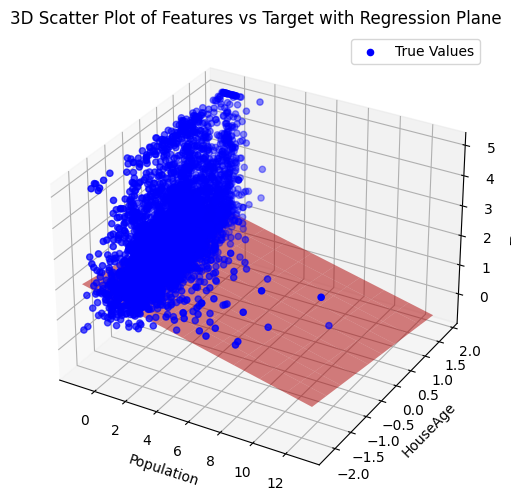

In [8]:
result0 = fedSgdPar(model=LinearRegressionModel(), T=40, K=100, C=0.1, E=1, lr=0.0001, noiid=True, verbose=False)


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

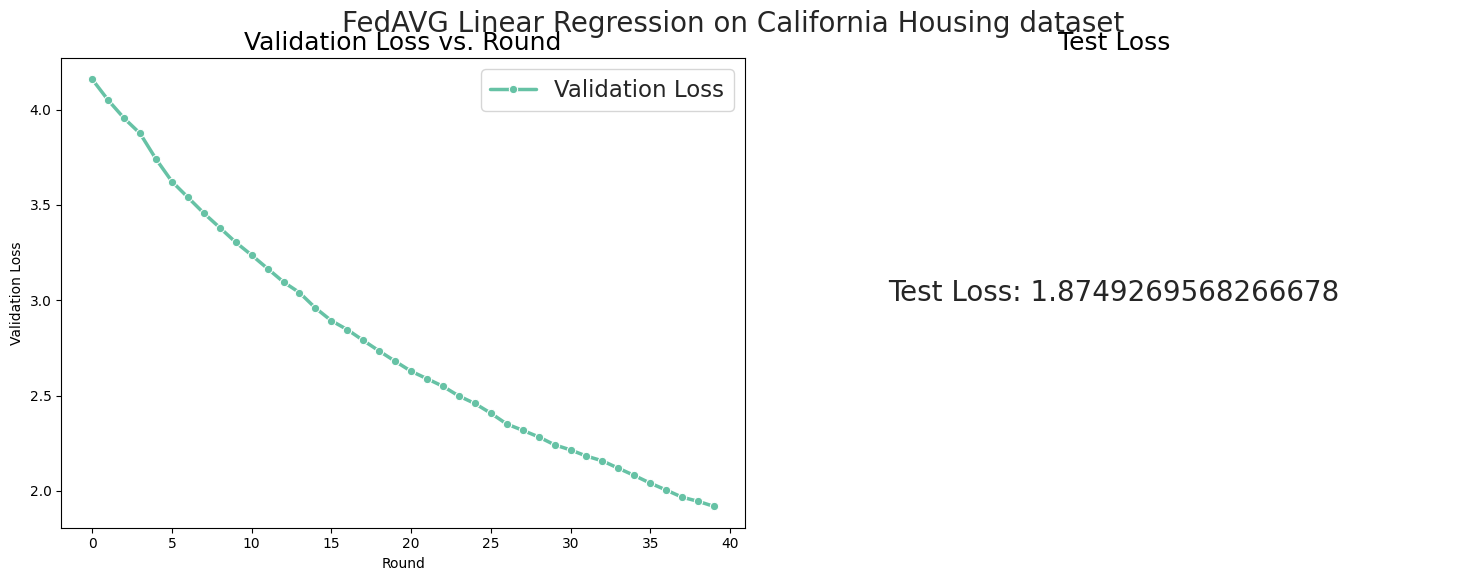

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5, 'axes.labelsize': 18})
sns.set_style("whitegrid")
sns.set_palette("Set2")
plt.rcParams['font.family'] = 'DejaVu Sans'

# Plot validation losses
val_losses = result0['val_losses']
sns.lineplot(x=range(len(val_losses)), y=val_losses, ax=axs[0], color=sns.color_palette()[0], marker='o', label='Validation Loss')
axs[0].set_xlabel('Round')
axs[0].set_ylabel('Validation Loss')
axs[0].set_title('Validation Loss vs. Round')
axs[0].legend()

# Setting integer ticks on x-axis
axs[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Plotting test loss as a text annotation
axs[1].text(0.5, 0.5, f'Test Loss: {result0["test_loss"]}', fontsize=20, ha='center', va='center')
axs[1].set_title('Test Loss')
axs[1].axis('off')  # Hide the axes for a cleaner look

# Title for the entire figure
plt.suptitle('FedAVG Linear Regression on California Housing dataset', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust title position
plt.show()

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Step 1: Initialize the Model
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(2, 1)

    def forward(self, x):
        return self.linear(x)

# Step 2: Create DataLoader
X = torch.randn(1, 2)  # 10 samples, 2 features
y = torch.randn(1, 1)  # 10 target values
dataset = TensorDataset(X, y)
data_loader = DataLoader(dataset, batch_size=10)

# Initialize the model, loss function, and optimizer
model = LinearRegressionModel()
loss_func = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Function to clip gradients
def per_sample_clip(model, clipping, norm):
    # Collect the gradients from each parameter
    grad_samples = [p.grad for p in model.parameters() if p.grad is not None]
    print("\nCollect the gradients from each parameter")
    for p in grad_samples:
      print(p)

    # Calculate norms for each parameter's gradients
    per_param_norms = [g.reshape(len(g), -1).norm(norm, dim=-1) for g in grad_samples]
    print("\nCalculate norms for each parameter's gradients")
    for p in per_param_norms:
      print(p)

    # Calculate per-sample norms
    per_sample_norms = torch.stack(per_param_norms, dim=1).norm(norm, dim=1)
    print("\nCalculate per-sample norms")
    for p in per_sample_norms:
      print(p)

    # Calculate the clipping factor
    per_sample_clip_factor = torch.div(clipping, (per_sample_norms + 1e-6)).clamp(max=1.0)
    print("\nCalculate the clipping factor")
    for p in per_sample_clip_factor:
      print(p)

    # Apply the clipping factor to each gradient
    for grad in grad_samples:
        factor = per_sample_clip_factor.reshape(per_sample_clip_factor.shape + (1,) * (grad.dim() - 1))
        grad.detach().mul_(factor.to(grad.device))
    print("\nApply the clipping factor to each gradient")
    for p in grad_samples:
      print(p)

    # Average the clipped gradients and set them back to parameters
    for param in model.parameters():
        if param.grad is not None:
            # Average the gradients and ensure the shape matches the parameter
            param.grad = param.grad.detach().mean(dim=0).view_as(param)  # Reshape to match param's shape
    print("\nAverage the clipped gradients and set them back to parameters")
    for p in model.parameters():
      print(p.grad)

# Step 3: Forward Pass
for x_batch, y_batch in data_loader:
    y_pred = model(x_batch)

    # Step 4: Compute Loss
    loss = loss_func(y_pred, y_batch)

    # Step 5: Backward Pass
    optimizer.zero_grad()
    loss.backward()

    # Inspect Gradients Before Clipping
    print("Gradients before clipping:")
    for param in model.parameters():
        if param.grad is not None:
            print(param.grad)

    # Step 6: Clip Gradients
    per_sample_clip(model, clipping=10, norm=2)

    # Inspect Gradients After Clipping
    print("\nGradients after clipping:")
    for param in model.parameters():
        if param.grad is not None:
            print(param.grad)

Gradients before clipping:
tensor([[ 1.4195, -0.6141]])
tensor([-0.8161])

Collect the gradients from each parameter
tensor([[ 1.4195, -0.6141]])
tensor([-0.8161])

Calculate norms for each parameter's gradients
tensor([1.5466])
tensor([0.8161])

Calculate per-sample norms
tensor(1.7487)

Calculate the clipping factor
tensor(1.)

Apply the clipping factor to each gradient
tensor([[ 1.4195, -0.6141]])
tensor([-0.8161])

Average the clipped gradients and set them back to parameters
tensor([[ 1.4195, -0.6141]])
tensor([-0.8161])

Gradients after clipping:
tensor([[ 1.4195, -0.6141]])
tensor([-0.8161])
